In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


<AxesSubplot:xlabel='DATE'>

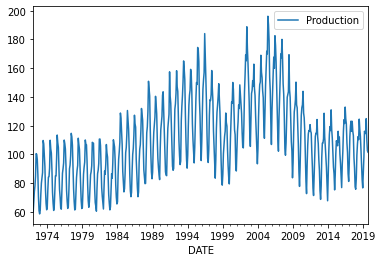

In [8]:
df.plot()

In [9]:
len(df)

573

In [10]:
test_size=24
test_ind = len(df)- test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
len(test)

24

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler=MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [22]:
model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
stopper=EarlyStopping(monitor='val_loss', patience=2)

In [27]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[stopper])

/home/shivanshu/Programs/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
531/531 [==============================] - 5s 6ms/step - loss: 0.0431 - val_loss: 0.0031
Epoch 2/20
531/531 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0041
Epoch 3/20
531/531 [==============================] - 3s 5ms/step - loss: 0.0047 - val_loss: 0.0031


<AxesSubplot:>

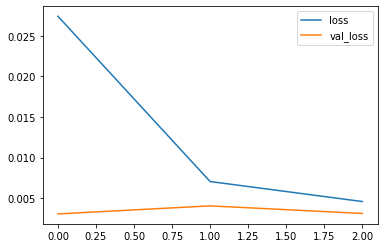

In [28]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [34]:
test_pred = []
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    curr_pred=model.predict(current_batch)[0]
    test_pred.append(curr_pred)
    current_batch=np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

In [36]:
true_pred=scaler.inverse_transform(test_pred)

In [37]:
test['Predictions'] = true_pred

<ipython-input-37-0dfcba9b5a0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


In [38]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,95.361367
2017-11-01,77.4378,91.667270
2017-12-01,75.8118,94.012343
2018-01-01,83.4343,103.082406
2018-02-01,99.4899,114.523916
2018-03-01,107.3152,124.241627
2018-04-01,112.4309,130.146649
2018-05-01,110.3544,131.845424
2018-06-01,124.5841,128.776462


<AxesSubplot:xlabel='DATE'>

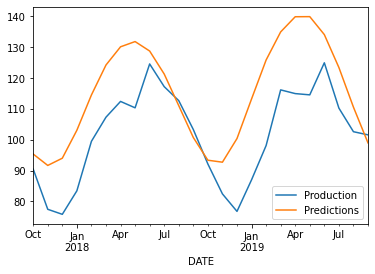

In [39]:
test.plot()

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

16.25950231195864